In [1]:
!pip install pybullet imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 5.8 MB/s eta 0:00:00


In [29]:
import numpy as np
import imageio_ffmpeg
import pybullet as p
import math

# Configura la simulazione e la fotocamera
p.connect(p.DIRECT)  # Usa la modalità senza GUI per evitare un impatto sulle prestazioni
p.resetSimulation() # Lui va chiamato la mattina appena apri il computer
p.setGravity(0, 0, -9.81)
p.setTimeStep(0.01)  # Imposta il passo temporale per la simulazione

# Aggiungi il percorso dei dati PyBullet
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [3]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git
%cd Real_Mega_Fufi/Robot/1LegTrail/

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 1359, done.
remote: Counting objects: 100% (364/364), done.
remote: Compressing objects: 100% (326/326), done.
remote: Total 1359 (delta 277), reused 37 (delta 37), pack-reused 995 (from 3)
Receiving objects: 100% (1359/1359), 14.27 MiB | 8.10 MiB/s, done.
Resolving deltas: 100% (886/886), done.
/content/Real_Mega_Fufi/Robot/1LegTrail


In [30]:
plane_pos = [0,0,0]
plane = p.loadURDF("plane.urdf", plane_pos, useFixedBase=True)

# position of the base of the model
PIP_position = [0,0,0]
orientation  = [0,0,0]
PIP_orientation = p.getQuaternionFromEuler(orientation)
PIPPA_id = p.loadURDF("PIPPA_oneleg.urdf", basePosition = PIP_position, baseOrientation = PIP_orientation, \
                      useFixedBase=False)


In [31]:
#change colors
p.changeVisualShape(PIPPA_id, -1, rgbaColor=[1, 0.65, 0, 1]) #terreno arancione
p.changeVisualShape(PIPPA_id, 0, rgbaColor=[0.5, 1, 0.5, 1]) #colonna verdino
p.changeVisualShape(PIPPA_id, 1, rgbaColor=[0.5, 0.8, 1, 1]) #colonna azzurrino

In [32]:
link_name_to_index = {p.getBodyInfo(PIPPA_id)[0].decode('UTF-8'):-1,}

for id in range(p.getNumJoints(PIPPA_id)):
  name = p.getJointInfo(PIPPA_id, id)[12].decode('UTF-8')
  link_name_to_index[name] = id


In [33]:
print(link_name_to_index)

{'Link_colonna': -1, 'Giunto_Link': 0, 'Gamba_Link': 1}


In [34]:

# Parametri della fotocamera
cam_target_pos = [0, 0, 0]
cam_distance = 1
cam_yaw, cam_pitch, cam_roll = 50, -30.0, 0
cam_width, cam_height = 480, 360
cam_up_axis_idx = 2
cam_fov = 60
cam_near_plane, cam_far_plane = 0.01, 100

# Imposta la registrazione del video
vid = imageio_ffmpeg.write_frames('simulation_output.mp4', (cam_width, cam_height), fps=30)
vid.send(None)  # Inizializza con un fotogramma vuoto


# Forza esterna da applicare
force_module = np.array([0.00005, 0, 0])
column_pos, coloum_or = p.getBasePositionAndOrientation(PIPPA_id)
force_position = column_pos
p.stepSimulation()

()

In [35]:

# Liste per registrare le posizioni
leg_positions_x, leg_positions_y, leg_position_z = [], [], []
joint_positions_x, joint_positions_y, joint_position_z = [], [], []


In [36]:
# Ciclo principale della simulazione
for step in range(4000):
    #print(f'\rtimestep {step}...', end='')
    if 50 <= step < 1000:
      # Applicare la forza esterna al primo passo della simulazione
      p.applyExternalForce(
          objectUniqueId= PIPPA_id,
          linkIndex=-1,
          forceObj=force_module,
          posObj=force_position,
          flags=p.WORLD_FRAME
        )

    # Registrazione della posizione della gamba
    leg_position, leg_orientation = p.getLinkState(PIPPA_id,1)[0:2]
    leg_positions_x.append(leg_position[0])
    leg_positions_y.append(leg_position[1])
    leg_position_z.append(leg_position[2])

    # Aggiorna il video
    # Calcola la vista e la proiezione della fotocamera
    cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(
        cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx
    )
    cam_projection_matrix = p.computeProjectionMatrixFOV(
        cam_fov, cam_width / cam_height, cam_near_plane, cam_far_plane
    )

    # Cattura l'immagine
    image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]

    # Scrivi il fotogramma nel video
    vid.send(np.ascontiguousarray(image))

    p.stepSimulation()  # Avanza di un passo nella simulazione

# Rilascia le risorse video
vid.close()
# Disconnessione dalla simulazione
p.disconnect()

In [37]:
# Ora visualizziamo il video registrato nel notebook
mp4 = open('simulation_output.mp4', 'rb').read()  # Leggi il file video
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()  # Convertilo in Base64

# Visualizza il video nel notebook Jupyter
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

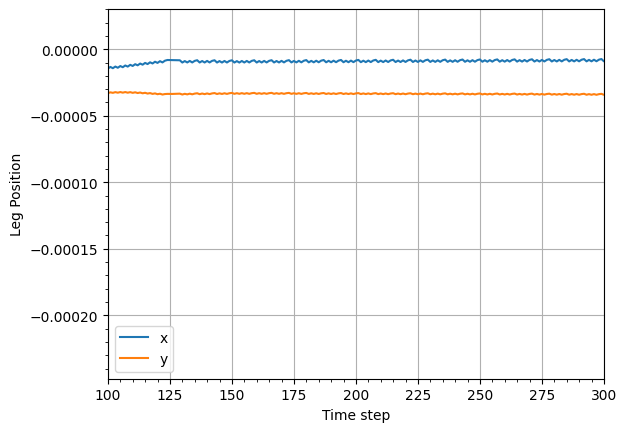

In [47]:
#plotting positions
plt.figure('Leg positions')
plt.plot(leg_positions_x, label='x')
plt.plot(leg_positions_y, label='y')
#plt.plot(leg_position_z, label='z')
plt.xlabel('Time step')
plt.ylabel('Leg Position')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.ylim(-0.05,0.0000)
plt.xlim(100, 300)
plt.show()